### 网格游戏

我们将讨论：
- in-place与out-of-place在实现中的区别；
- 同[02-MDP-and-Bellman-Equation.ipynb](02-MDP-and-Bellman-Equation.ipynb)，我们将改进[Zhang的代码](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter04/grid_world.py)，尝试在jupyter中查看最优动作。

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table
%matplotlib inline

WORLD_SIZE = 4
# left, up, right, down
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTION_PROB = 0.25


def is_terminal(state):
    x, y = state
    return (x == 0 and y == 0) or (x == WORLD_SIZE - 1 and y == WORLD_SIZE - 1)


def step(state, action):
    if is_terminal(state):
        return state, 0

    next_state = (np.array(state) + action).tolist()
    x, y = next_state

    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        next_state = state

    reward = -1
    return next_state, reward


def draw_image(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(image):
        tb.add_cell(i, j, width, height, text=val,
                    loc='center', facecolor='white')

        # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')
    ax.add_table(tb)


def compute_state_value(in_place=True, discount=1.0):
    new_state_values = np.zeros((WORLD_SIZE, WORLD_SIZE))
    iteration = 0
    while True:
        if in_place:
            # 在 in place 下， state_values 和 new_state_values 是同一个数组，不同名字
            state_values = new_state_values
        else:
            state_values = new_state_values.copy()
        old_state_values = state_values.copy()

        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                value = 0
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    value += ACTION_PROB * (reward + discount * state_values[next_i, next_j])
                # 在 in place 下，对 new_state_values 进行更新即对 state_values 更新；
                # in place 下，对 state_values 立即更新，即会对本次迭代中的其他状态产生影响
                # 否则，使用 out of place 迭代策略，本次迭代中贝尔曼公式用到的 state_values 都来自上次迭代
                new_state_values[i, j] = value

        max_delta_value = abs(old_state_values - new_state_values).max()
        if max_delta_value < 1e-4:
            break

        iteration += 1

    return new_state_values, iteration


def figure_4_1():
    # While the author suggests using in-place iterative policy evaluation,
    # Figure 4.1 actually uses out-of-place version.
    _, asycn_iteration = compute_state_value(in_place=True)
    values, sync_iteration = compute_state_value(in_place=False)
    draw_image(np.round(values, decimals=2))
    print('In-place: {} iterations'.format(asycn_iteration))
    print('Synchronous: {} iterations'.format(sync_iteration))

    plt.plot()

In-place: 113 iterations
Synchronous: 172 iterations


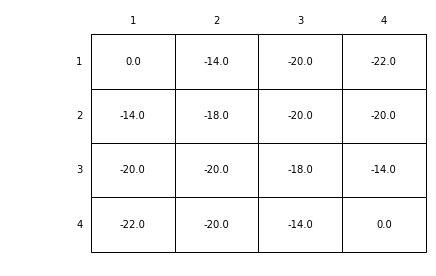

In [16]:
figure_4_1()

**请注意：**
- 上面 in-place 与 out-of-place 的实现区别；
- in-place 与 out-of-place 在迭代速度上的差异。

编程实现上述过程可以有两种方式。第一种情况就是，我们使用两个数组，一个表示$v_{k+1}(s)$，相应另一个是$v_k(s)$。这种情况下，更新了某个状态值并不会影响到这次迭代其它状态值的更新。

因为在一轮更新中$v_k(s)$保持不变。这种更新方式和更新顺序没有关系；另一种方式是使用一个数组，替代(in-place)地更新，计算出新的值后立刻替代掉该状态旧的值，这样一轮迭代中一些状态值的更新可能会受到其它状态值更新的影响，in-place也能保证收敛到$v_k(s)$，且更快，因此我们通常采用in-place方法。

每轮迭代我们都更新状态空间每个状态的值，这叫做一个sweep，in-place的sweep顺序对收敛的速率有很大影响。